In [25]:
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import pandas as pd
import seaborn as sns
from fuzzywuzzy import fuzz, process
from nltk.corpus import stopwords
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import keras
import numpy as np
import warnings
import re
import pickle

# nltk.download('stopwords')
# nltk.download('punkt')
stop = stopwords.words('english')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('./data/train.csv')

In [3]:
df.head()

,id,query,product_title,product_description,median_relevance,relevance_variance
0,1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000
1,2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000
2,4,projector,ViewSonic Pro8200 DLP Multimedia Projector,NaN,4,0.471
3,5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000
4,7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10158 entries, 0 to 10157
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10158 non-null  int64  
 1   query                10158 non-null  object 
 2   product_title        10158 non-null  object 
 3   product_description  7714 non-null   object 
 4   median_relevance     10158 non-null  int64  
 5   relevance_variance   10158 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 476.3+ KB


In [5]:
df['target'] = df['median_relevance'].astype('str')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10158 entries, 0 to 10157
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10158 non-null  int64  
 1   query                10158 non-null  object 
 2   product_title        10158 non-null  object 
 3   product_description  7714 non-null   object 
 4   median_relevance     10158 non-null  int64  
 5   relevance_variance   10158 non-null  float64
 6   target               10158 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 555.6+ KB


In [7]:
df.isnull().sum()

id                        0
query                     0
product_title             0
product_description    2444
median_relevance          0
relevance_variance        0
target                    0
dtype: int64

In [8]:
df['prod_clean'] = df['product_title'].str.lower().apply(lambda x: ' '.join(
    [word for word in x.split() if word not in (stop)]))
df['prod_clean'] = df['prod_clean'].str.replace('\d+', '')
df['desc_clean'] = df['product_description'].str.lower().fillna('none').apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['desc_clean'] = df['desc_clean'].str.replace('\d+', '')

In [9]:
df.head()

,id,query,product_title,product_description,median_relevance,relevance_variance,target,prod_clean,desc_clean
0,1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000,1,accent pillow heart design - red/black,red satin accent pillow embroidered heart blac...
1,2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000,4,set battery operated multi led train christma...,set battery operated train christmas lights i...
2,4,projector,ViewSonic Pro8200 DLP Multimedia Projector,NaN,4,0.471,4,viewsonic pro dlp multimedia projector,none
3,5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000,4,concept housewares wr- solid-wood ceiling/wall...,"like silent sturdy tree, southern enterprises ..."
4,7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471,2,wintergreen lighting christmas led light bulb ...,"wtgr features nickel base, , average hours, ac..."


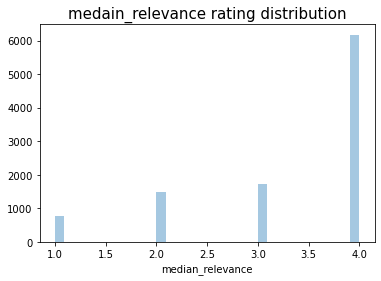

In [10]:
sns.distplot(df['median_relevance'], kde=False)
plt.title('medain_relevance rating distribution', fontsize=15)
plt.show()

In [11]:
df['prod_fuzzy'] = [fuzz.partial_ratio(df['query'][x], df['prod_clean'][x])
                    for x in range(len(df))]
df['desc_fuzzy'] = [fuzz.partial_ratio(df['query'][x], df['desc_clean'][x])
                    for x in range(len(df))]

In [12]:
df['prod_desc'] = [fuzz.partial_ratio(df['prod_clean'][x], df['desc_clean'][x])
                   for x in range(len(df))]

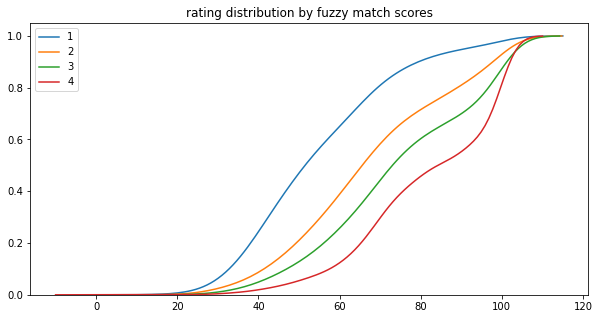

In [13]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['median_relevance'] == 1]
            ['prod_fuzzy'], label=1, cumulative=True)
sns.kdeplot(df[df['median_relevance'] == 2]
            ['prod_fuzzy'], label=2, cumulative=True)
sns.kdeplot(df[df['median_relevance'] == 3]
            ['prod_fuzzy'], label=3, cumulative=True)
sns.kdeplot(df[df['median_relevance'] == 4]
            ['prod_fuzzy'], label=4, cumulative=True)
plt.legend(loc='best')
plt.title('rating distribution by fuzzy match scores')
plt.show()

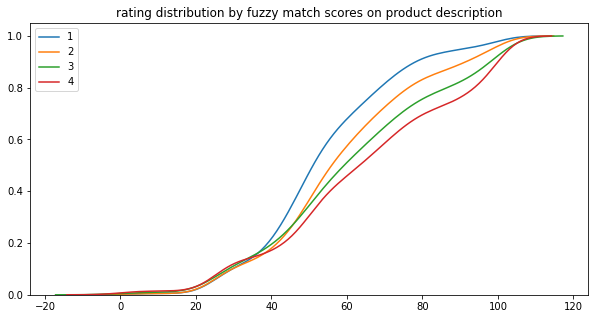

In [14]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['median_relevance'] == 1]
            ['desc_fuzzy'], label=1, cumulative=True)
sns.kdeplot(df[df['median_relevance'] == 2]
            ['desc_fuzzy'], label=2, cumulative=True)
sns.kdeplot(df[df['median_relevance'] == 3]
            ['desc_fuzzy'], label=3, cumulative=True)
sns.kdeplot(df[df['median_relevance'] == 4]
            ['desc_fuzzy'], label=4, cumulative=True)
plt.legend(loc='best')
plt.title('rating distribution by fuzzy match scores on product description')
plt.show()

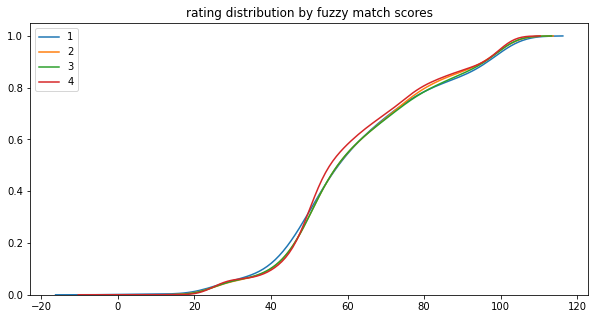

In [15]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['median_relevance'] == 1]
            ['prod_desc'], label=1, cumulative=True)
sns.kdeplot(df[df['median_relevance'] == 2]
            ['prod_desc'], label=2, cumulative=True)
sns.kdeplot(df[df['median_relevance'] == 3]
            ['prod_desc'], label=3, cumulative=True)
sns.kdeplot(df[df['median_relevance'] == 4]
            ['prod_desc'], label=4, cumulative=True)
plt.legend(loc='best')
plt.title('rating distribution by fuzzy match scores')
plt.show()

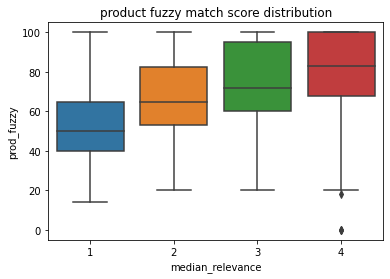

In [16]:
sns.boxplot(x='median_relevance', y='prod_fuzzy', data=df)
plt.title('product fuzzy match score distribution')
plt.show()

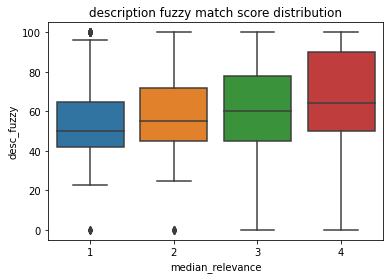

In [17]:
sns.boxplot(x='median_relevance', y='desc_fuzzy', data=df)
plt.title('description fuzzy match score distribution')
plt.show()

In [18]:
df['query_len'] = df['query'].str.count(' ')+1

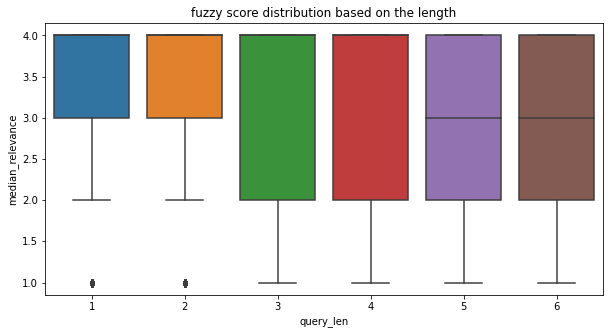

In [19]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='query_len', y='median_relevance', data=df)
plt.title('fuzzy score distribution based on the length')
plt.show()

### Text Features

In [20]:
query_all = df['query'].str.cat()
tokens_nonum = re.sub(r'\d+', '', query_all)
tokens = word_tokenize(tokens_nonum)
tokens_nostop = [word for word in tokens if not word in stop]
bow_simple = Counter(tokens_nostop)

In [21]:
tup = bow_simple.most_common(30)
tup_list = [tup[i][0] for i in range(len(tup))]

In [26]:
with open('data/tup_list.pkl', 'wb') as f:
    pickle.dump(tup_list, f)

In [22]:
for term in tup_list:
    df[term] = df['query'].str.contains(term)

In [23]:
df.set_index('id', inplace=True)

In [24]:
df.to_csv('./data/df_clean.csv')